In [1]:


from typing import *
import importlib
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import seaborn as sns
import pandas as pd
from torch import nn, Tensor
from torch.distributions import Distribution, Dirichlet as TorchDirichlet
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.distributions import Bernoulli
from plotting import make_vae_plots
import plotting
importlib.reload(plotting)
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from collections import defaultdict
import torch.nn.functional as F

In [2]:

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [3, 7]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


In [3]:

batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))
sns.set_style("whitegrid")

images, labels = next(iter(train_loader))


def reduce(x: Tensor) -> Tensor:
    """Reduce only if tensor has more than one dimension."""
    return x if x.ndim == 1 else x.view(x.size(0), -1).sum(dim=-1)



c:\Users\Lauge\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\Users\Lauge\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
from enum import Enum

class LatentType(Enum):
    GAUSSIAN = 1
    DIRICHLET = 2
    CONTINUOUSCATEGORICAL = 3

In [5]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(z | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, I)`.
    """
    def __init__(self, mu: Tensor, log_sigma: Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu`: {mu.shape} and `log_sigma`: {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.log_sigma = log_sigma
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """ε ~ N(0, I)"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """Sample z ~ N(z | mu, sigma) (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """Sample z ~ N(z | mu, sigma) (with the reparameterization trick)"""
        eps = self.sample_epsilon()
        return self.mu + self.sigma * eps
    
    def log_prob(self, z: Tensor) -> Tensor:
        log_p = -0.5 * (((z - self.mu) / self.sigma) ** 2 + 2 * self.log_sigma + math.log(2 * math.pi))
        if log_p.ndim > 1:
            log_p = log_p.sum(dim=-1)
        return log_p


In [6]:
class ReparameterizedDirichlet(Distribution):
    """
    A reparameterized Dirichlet distribution `Dir(z | alpha)` compatible with the
    reparameterization trick (via PyTorch's rsample on Gamma variables).
    """
    def __init__(self, alpha: Tensor):
        # alpha can be [batch_size, latent_dim] or [latent_dim]
        assert (alpha > 0).all(), "All concentration parameters (alpha) must be positive"
        self.alpha = alpha
        self._dist = TorchDirichlet(alpha)

    def sample(self) -> Tensor:
        """Sample z ~ Dir(alpha) (without gradients)."""
        with torch.no_grad():
            return self._dist.sample()

    def rsample(self) -> Tensor:
        """Sample z ~ Dir(alpha) (with gradients via reparameterization)."""
        return self._dist.rsample()

    def log_prob(self, z: Tensor) -> Tensor:
        """Compute log p(z | alpha)."""
        return self._dist.log_prob(z)
    


In [7]:
import torch
import torch.nn.functional as F
from torch.distributions import Distribution

class ReparameterizedContinuousCategorical(Distribution):
    """
    A reparameterized Continuous Categorical (Gumbel-Softmax) distribution.
    Samples from a relaxed categorical using the Gumbel-Softmax trick.
    """
    def __init__(self, logits: torch.Tensor, temperature: float = 1.0):
        super().__init__()
        self.logits = logits
        self.temperature = temperature

    def sample(self) -> torch.Tensor:
        """Sample without gradients."""
        with torch.no_grad():
            return F.gumbel_softmax(self.logits, tau=self.temperature, hard=False, dim=-1)
        
    def rsample(self) -> torch.Tensor:
        """Reparameterized sample using the Gumbel-Softmax trick."""
        return F.gumbel_softmax(self.logits, tau=self.temperature, hard=False, dim=-1)

    def log_prob(self, z: torch.Tensor) -> torch.Tensor:
        """Compute approximate log-probability under the relaxed categorical."""
        # This is not an exact density but a differentiable approximation
        log_q = torch.sum(z * F.log_softmax(self.logits, dim=-1), dim=-1)
        return log_q


In [8]:

class VariationalInference(nn.Module):
    def __init__(self, beta: float = 1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model: nn.Module, x: Tensor):
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the KL divergence term
        kl = log_qz - log_pz
        
        # ELBO: log p(x|z) - KL(q||p)
        elbo = log_px - kl
        
        # β-ELBO: log p(x|z) - β * KL(q||p)
        beta_elbo = log_px - self.beta * kl
        
        # loss = -E_q[Lβ]
        loss = -beta_elbo.mean()
        
        # diagnostics for monitoring
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px': log_px, 'kl': kl}
            
        return loss, diagnostics, outputs


In [9]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_shape: torch.Size, latent_features: int, latent_type: LatentType, tau_start:float = 2.0) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.latent_type = latent_type
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        # temperature for Gumbel–Softmax
        self.tau = tau_start

        self.encoder = nn.Sequential(
            nn.Linear(self.observation_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_features if latent_type == LatentType.GAUSSIAN else latent_features)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, self.observation_features)
        )

        if self.latent_type == LatentType.GAUSSIAN:
            self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2 * latent_features])))
        elif self.latent_type == LatentType.DIRICHLET:
            self.register_buffer('alpha_prior', torch.ones(torch.Size([1, latent_features])))
        else:  # continuous categorical
            self.register_buffer('logits_prior', torch.zeros(torch.Size([1, latent_features])))

    def posterior(self, x: torch.Tensor):
        h_x = self.encoder(x)
        if self.latent_type == LatentType.GAUSSIAN:
            mu, log_sigma = h_x.chunk(2, dim=-1)
            return ReparameterizedDiagonalGaussian(mu, log_sigma)
        elif self.latent_type == LatentType.DIRICHLET:
            alpha = F.softplus(h_x) + 1e-4
            return ReparameterizedDirichlet(alpha)
        else:  # continuous categorical
            return ReparameterizedContinuousCategorical(h_x)

    def prior(self, batch_size: int = 1):
        if self.latent_type == LatentType.GAUSSIAN:
            prior_params = self.prior_params.expand(batch_size, -1)
            mu, log_sigma = prior_params.chunk(2, dim=-1)
            return ReparameterizedDiagonalGaussian(mu, log_sigma)
        elif self.latent_type == LatentType.DIRICHLET:
            alpha = self.alpha_prior.expand(batch_size, -1)
            return ReparameterizedDirichlet(alpha)
        else:  # continuous categorical
            logits = self.logits_prior.expand(batch_size, -1)
            return ReparameterizedContinuousCategorical(logits)
        

    def observation_model(self, z: torch.Tensor) -> Distribution:
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape)
        return Bernoulli(logits=px_logits, validate_args=False)


    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)

        # encode
        qz = self.posterior(x)

        # prior
        pz = self.prior(batch_size=x.size(0))


        z = qz.rsample()

        # decode
        px = self.observation_model(z)

        return {"px": px, "pz": pz, "qz": qz, "z": z}
    
    def sample_from_prior(self, batch_size: int = 100):
        """Sample z ~ p(z) and return p(x|z)."""
        pz = self.prior(batch_size=batch_size)

        # sample latent variable
        z = pz.rsample() if hasattr(pz, "rsample") else pz.sample()

        # decode
        px = self.observation_model(z)

        return {"px": px, "pz": pz, "z": z}

    def sample_from_posterior(self, x: torch.Tensor):
        """Sample z ~ q(z|x) and return p(x|z)."""
        x = x.view(x.size(0), -1)

        # encode
        qz = self.posterior(x)

        # sample latent variable
        z = qz.rsample() if hasattr(qz, "rsample") else qz.sample()

        # decode
        px = self.observation_model(z)

        return {"px": px, "qz": qz, "z": z}




In [10]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 2
vae = VariationalAutoencoder(images[0].shape, latent_features,latent_type = LatentType.CONTINUOUSCATEGORICAL)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

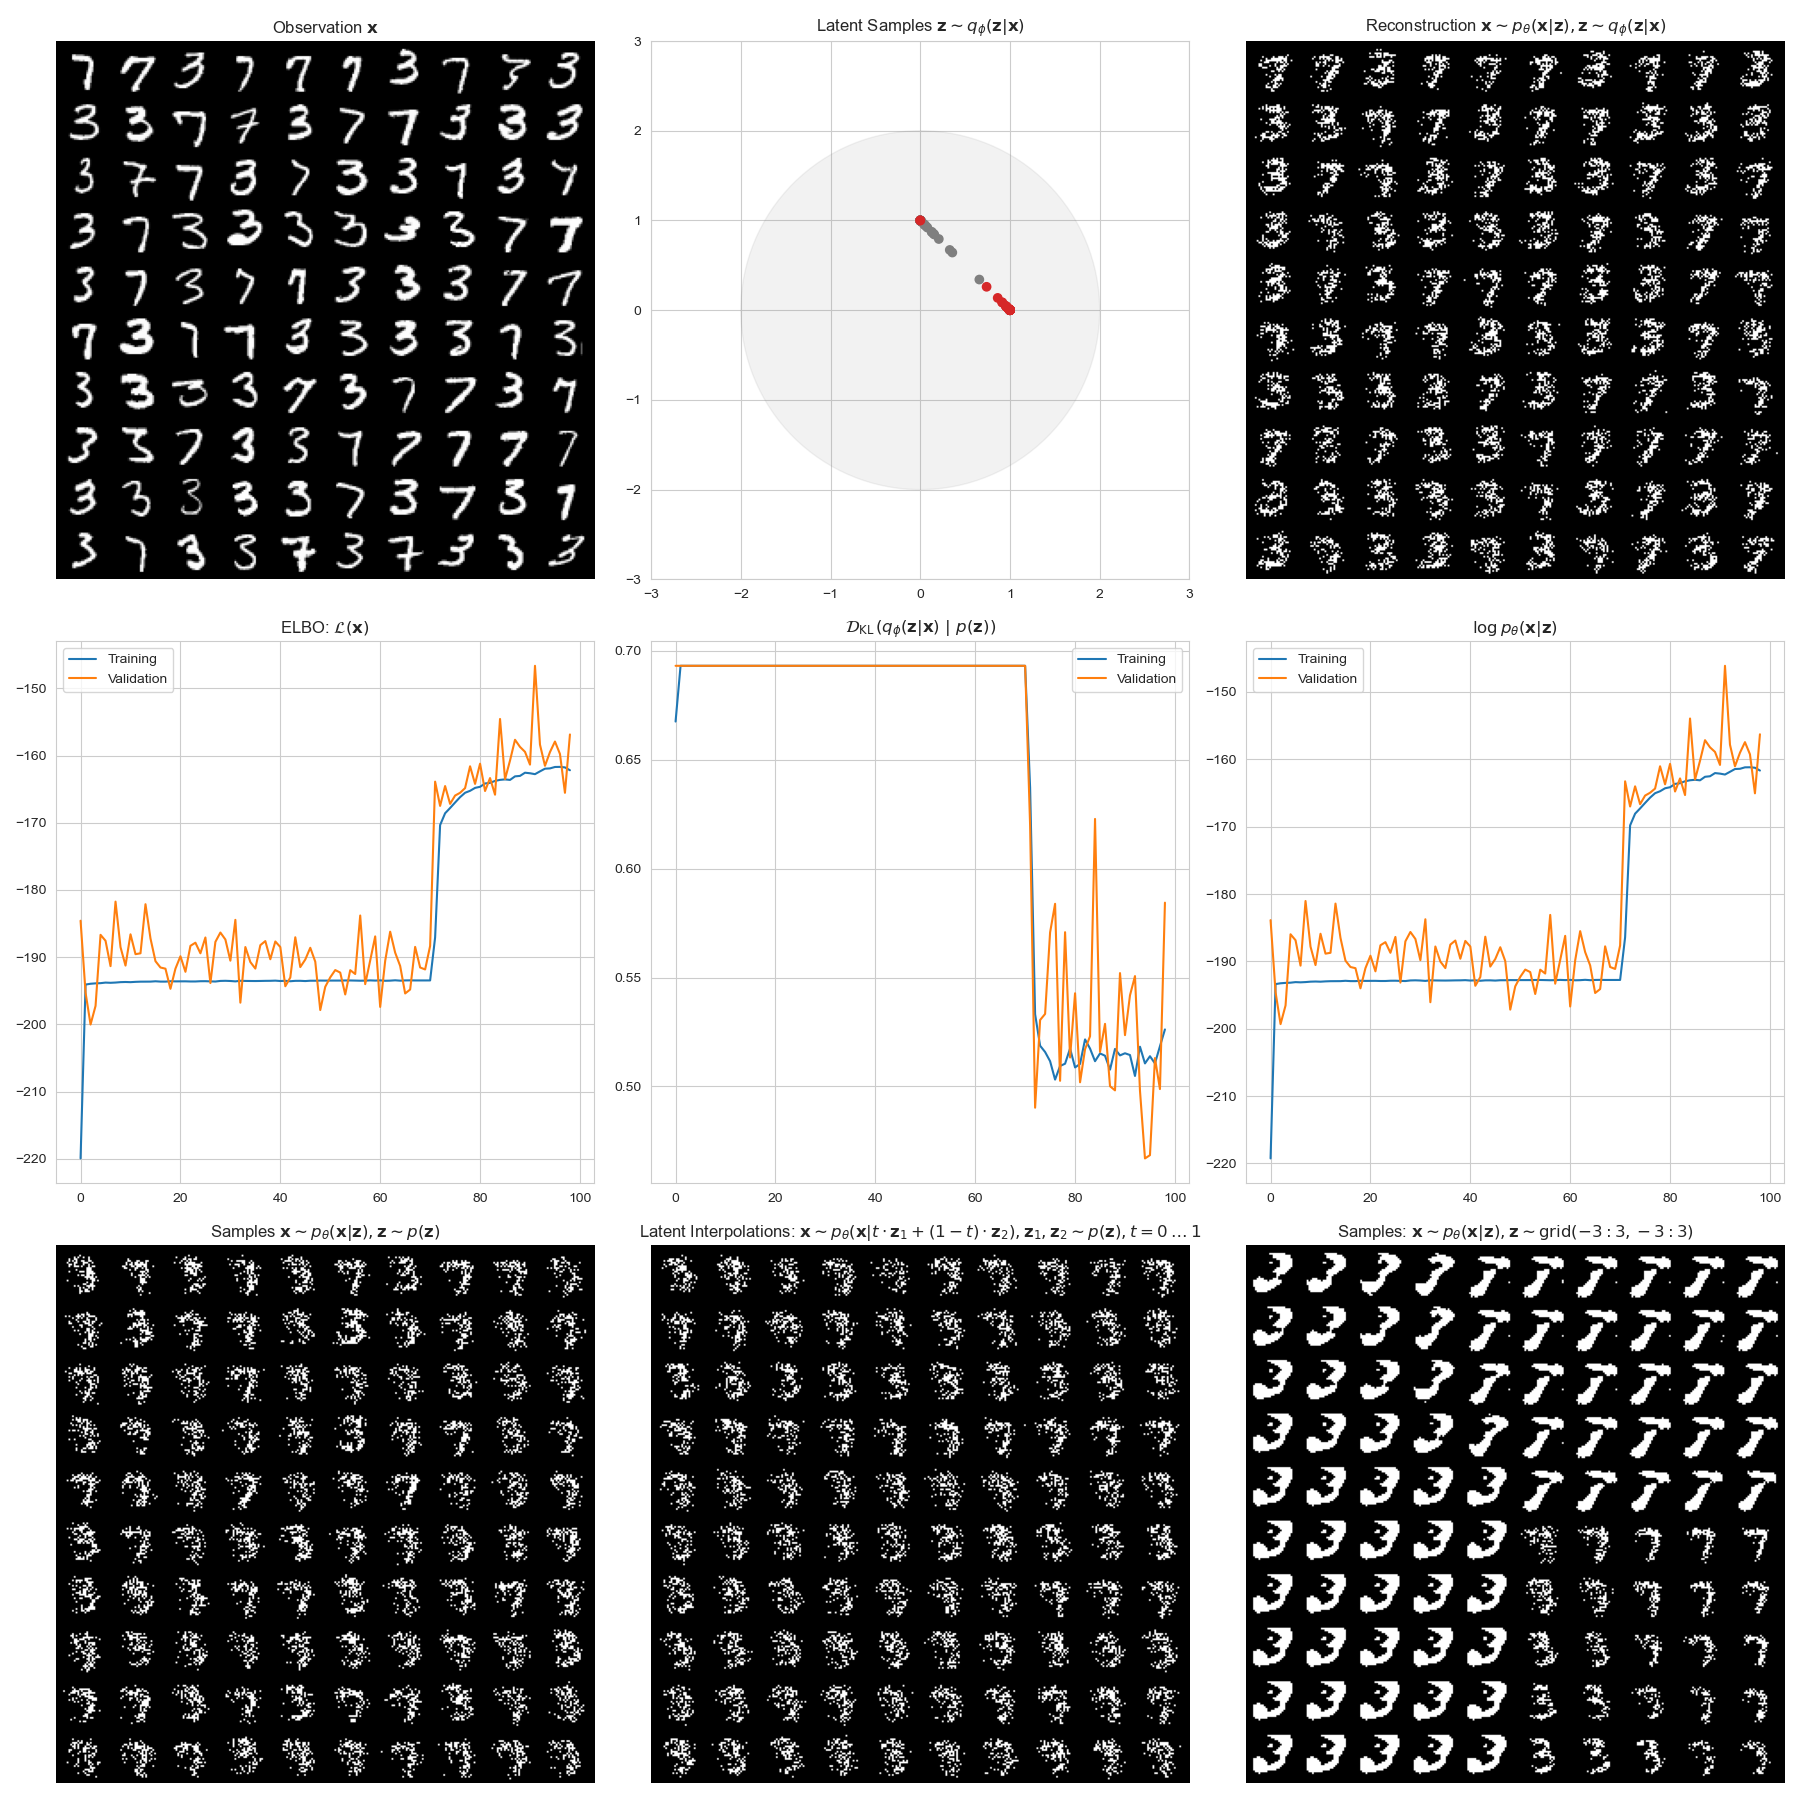

In [81]:
num_epochs = 5
from plotting import make_vae_plots

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

vae = vae.to(device)

# annealing parameters
tau_min = 0.5
anneal_rate = 0.0003
kl_warmup_epochs = 20  # number of epochs to reach full β
max_beta = 0.3

while epoch < num_epochs:
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()


    # KL warmup: gradually increase β
    vi.beta = min(max_beta, epoch / kl_warmup_epochs)

    # temperature annealing (only for continuous categorical)
    if vae.latent_type == "continuous_categorical":
        vae.tau = max(vae.tau * np.exp(-anneal_rate * epoch), tau_min)

    #print(f"Epoch {epoch}: beta = {vi.beta:.4f}", end="")
    # if vae.latent_type == "continuous_categorical":
    #     print(f", tau = {vae.tau:.4f}")
    # else:
    #     print()

    # training loop
    for x, y in train_loader:
        x = x.to(device)

        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # validation
    with torch.no_grad():
        vae.eval()
        x, y = next(iter(test_loader))
        x = x.to(device)
        loss, diagnostics, outputs = vi(vae, x)
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]

    # visualize
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)
